In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model

In [2]:
root = '/kaggle/input/140k-real-and-fake-faces'

train_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
val_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [3]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


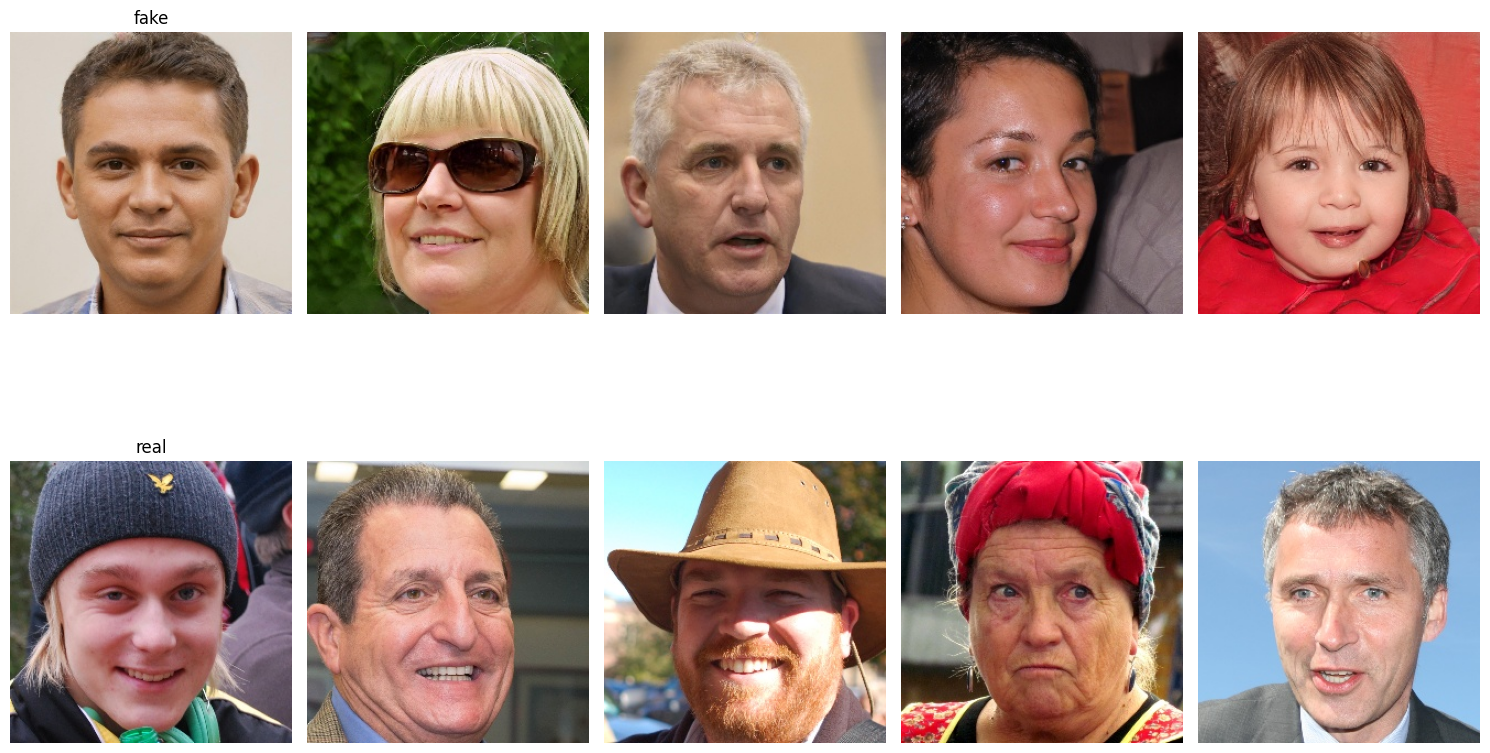

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define class names
class_names = ['fake', 'real']
num_images = 5

plt.figure(figsize=(15, 10))

# Plot sample images from training directory
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    # Plot title for the class
    plt.subplot(len(class_names), num_images, i * num_images + 1)
    plt.title(class_name)
    plt.axis('off')
    
    # Plot sample images
    for j in range(num_images):
        img_path = os.path.join(class_dir, images[j])
        img = mpimg.imread(img_path)
        plt.subplot(len(class_names), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)
target_size = (256,256)
batch_size = 32  # Update this according to your batch size

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
# Verify class distribution
print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", val_generator.class_indices)

Training class distribution: {'fake': 0, 'real': 1}
Validation class distribution: {'fake': 0, 'real': 1}


In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Build the CNN model
model = Sequential([
    Input(shape=(256, 256, 3)),  # Define the input shape explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    #Dropout(0.5),  # Uncomment if regularization is needed
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,584,961 (112.86 MB)

 Trainable params: 29,584,961 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5  # Adjust as needed
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733728596.509488      95 service.cc:145] XLA service 0x782720005a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733728596.509556      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733728596.509561      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   2/3125 ━━━━━━━━━━━━━━━━━━━━ 3:03 59ms/step - accuracy: 0.4688 - loss: 2.9385  

I0000 00:00:1733728602.891729      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 780s 247ms/step - accuracy: 0.6967 - loss: 0.5822 - val_accuracy: 0.8288 - val_loss: 0.3736
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 286s 91ms/step - accuracy: 0.8829 - loss: 0.2730 - val_accuracy: 0.9085 - val_loss: 0.2267
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 252s 80ms/step - accuracy: 0.9388 - loss: 0.1537 - val_accuracy: 0.9387 - val_loss: 0.1530
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 259s 83ms/step - accuracy: 0.9649 - loss: 0.0936 - val_accuracy: 0.9425 - val_loss: 0.1458
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 82ms/step - accuracy: 0.9772 - loss: 0.0611 - val_accuracy: 0.9499 - val_loss: 0.1488


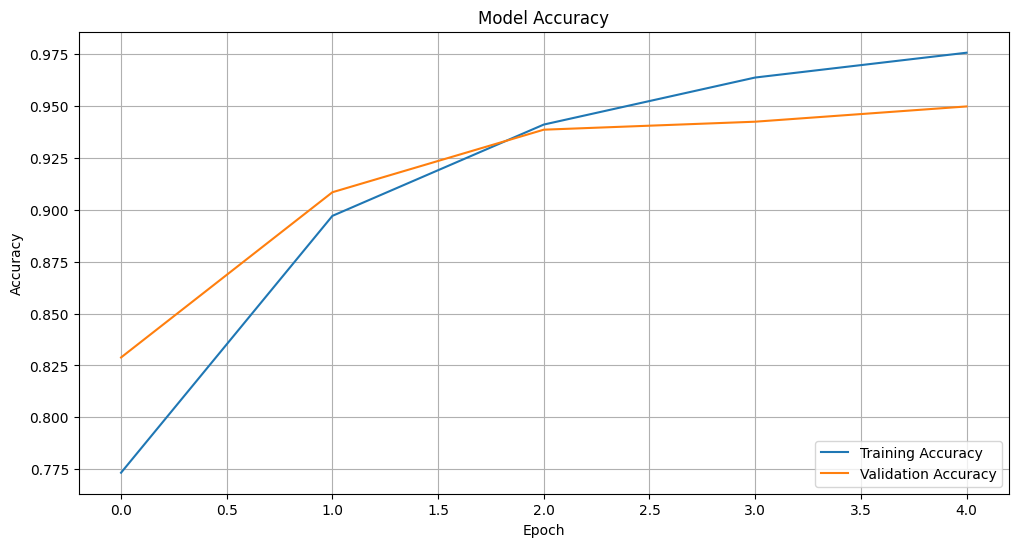

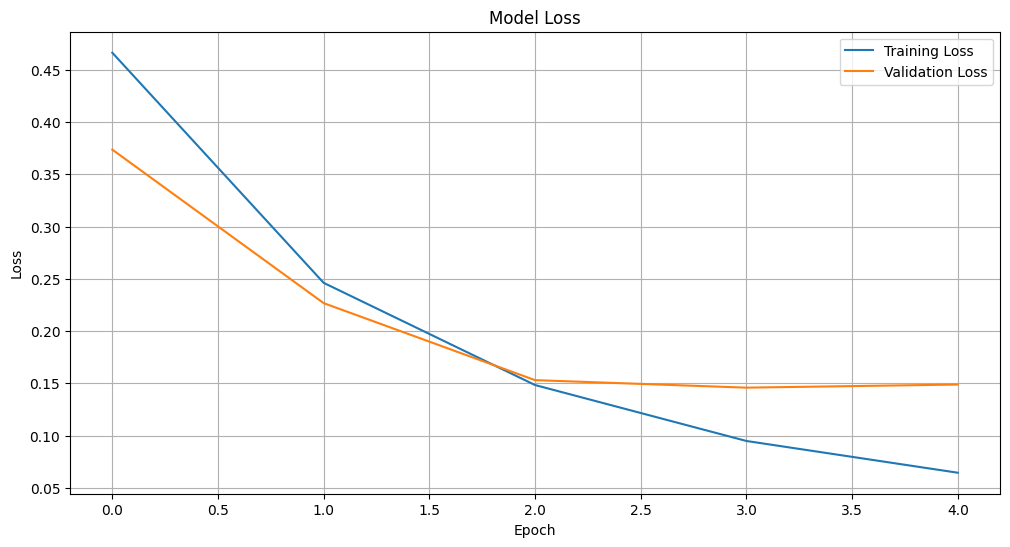

In [10]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [11]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 248ms/step
              precision    recall  f1-score   support

        fake       0.95      0.95      0.95     10000
        real       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



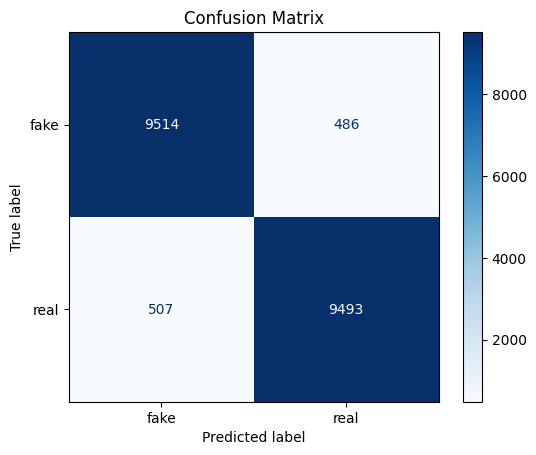

In [12]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.save('realvsfake_image_detection.h5')

In [14]:
from IPython.display import FileLink
FileLink(r'realvsfake_image_detection.h5')

/kaggle/working/realvsfake_image_detection.h5